In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (10,16)

import logging
logger = logging.getLogger()

7 Clustering
=======

**Goal**: points in the same cluster have a small distance from one other, while points in different clusters are at a large distance from one another.

### 7.1 Introduction to Clustering Techniques
#### 7.1.1 Points, Spaces, Distances
A dataset suitable for clustering is a collection of points, which are objects belonging to some space.

distance measure:     
1. nonnegative.    
2. symmetric.     
3. obey the triangle inequality.    

#### 7.1.2 Clustering Strategies
two groups:      
1. Hierarchinal or agglomerative algorithms.       
   Combine, bottom-to-top.
   
2. Point assignment.    
   iteration
   
   
A key distinction:      
Euclidean space can summarize a collection of points by their *centroid*.

### 7.1.3 The Curse of Dimensionality
It refers that a number of unintuitive properties of high-dimensional Euclidean space.

1. Almost all pairs of points are equally far away from one another.

2. Almost any two vectors are almost orthogomal.

`%todo: Proof`

#### 7.1.4 Exercises for Section 7.1
##### 7.1.1
\begin{align}
E[d(x,y)] &= \int_{y=0}^1 \int_{x=0}^1 |x - y| \, \mathrm{d}x \, \mathrm{d}y \\
          &= \int_{y=0}^1 \int_{x=0}^{y} (y-x) \, \mathrm{d}x + \int_{x=y}^{1} (x-y) \, \mathrm{d}x \, \mathrm{d}y \\
          &= \int_{y=0}^1 \frac{1}{2} y^2 + \frac{1}{2} (1-y)^2 \, \mathrm{d}y \\
          &= \frac{1}{3}
\end{align}

#### 7.1.2 
Because: $$\sqrt{\frac{{|x_1|}^2+{|x_2|}^2}{2}} \geq \frac{|x_1|+|x_2|}{2}$$
We have:
$$\sqrt{\frac{{|x_1 - x_2|}^2+{|y_1 - y_2|}^2}{2}} \geq \frac{|x_1 - x_2|+|y_1 - y_2|}{2}$$
So:
$$E[d(\mathbf{x}, \mathbf{y})] \geq \frac{\sqrt{2}}{3}$$

While:
$$\sqrt{{|x_1 - x_2|}^2+{|y_1 - y_2|}^2} \leq |x_1 - x_2|+|y_1 - y_2|$$
So:
$$E[d(\mathbf{x}, \mathbf{y})] \leq \frac{2}{3}$$

Above all:
$$\frac{\sqrt{2}}{3} \leq E[d(\mathbf{x}, \mathbf{y})] \leq \frac{2}{3}$$

#### 7.1.3
for $x_i y_i$ of numerator, there are four cases: $1=1\times1, 1=-1\times-1$ and $-1=1\times-1, -1=-1\times1$. So both 1 and -1 are $\frac{1}{2}$ probility. So the expected value of their sum is 0.

Hence, the expected value of cosine is 0, as $d$ grows large.  

### 7.2 Hierarchinal Clustering
This algorithm can only be used for relatively small datasets.

procedure:     
We begin with every point in its own cluster. As time goes on, larger clusters will be constructed by combining two smaller clusters.      
Hence we have to decide in advance:    

1. How to represent cluster?      
   + For Euclidean space, use centriod.     
   + For Non-Euclidean space, use clustroid.     
     **clustroid**:     
     - the point is close to all the points of the cluster.    
     - minimizes the sum of the distance to the other points.     
     - minimizes the maximum distance to another point.     
     - minimizes the sum of the squares of the distances to the other points.    

2. How to choose clusters to merge?      
   + shortest distance between clusters.      
   + the minimum of the distance between any two points.    
   + the average distance of all pairs of points.     
   + Combine the two clusters whose resulting cluster has the lowerst radius(the maximum distance between all the points and the centriod).       
     modification:      
     - lowest average distance between a point and the centriod.     
     - the sum of the squares of the distances between the points and the centriod.     
   + Cobine the two clusters whose resulting cluster has the smallest diameter(the maximum distance between any two points of the cluster).       
     The radius and diameter are not related directly, but there is a tendecy for them to be proportional.

3. When to stop?    
   + how many clusters expected?     
   + When at some point the best combination of existing clusters produces a cluster that is inadequate.     
     - threshold of average distance of points to its centriod.     
     - threshold of the diameter of the new cluster.    
     - threshold of the density of the new cluster.       
     - track the average diameter of all the current clusters. stop if take a sudden jump.
   + reach one cluster. $\to$ tree.     
     eg. genome $\to$ common ancestor.     
     
There is no substantial change in the option for stopping citeria and combining citeria when we move from Euclidean to Non-Euclidean spaces.

,cluster,x,y
0,0,4,10
1,1,7,10
2,2,4,8
3,3,6,8
4,4,3,4
5,5,10,5
6,6,12,6
7,7,11,4
8,8,2,2
9,9,5,2


/Users/facaiyan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


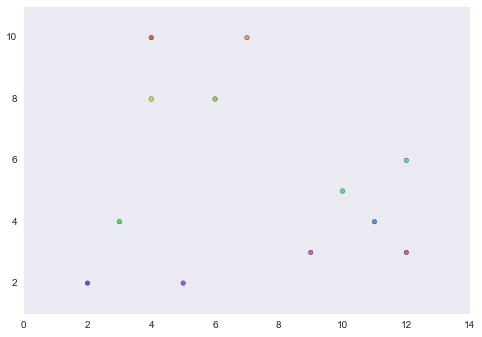

In [2]:
# Example 7.2
logger.setLevel('WARN')

points = np.array([
                        [4, 10],
                        [7, 10],
                        [4, 8],
                        [6, 8],
                        [3, 4],
                        [10, 5],
                        [12, 6],
                        [11, 4],
                        [2, 2],
                        [5, 2],
                        [9, 3],
                        [12, 3]
                   ],
                  dtype=np.float
)

x, y = points[:,0], points[:,1]
cluster = range(len(x))
#cluster_colors = plt.get_cmap('hsv')(np.linspace(0, 1.0, len(cluster)))
cluster_colors = sns.color_palette("hls", len(cluster))
plt.scatter(x, y, c=map(lambda x: cluster_colors[x], cluster))

df_points = pd.DataFrame({
                            'x': x,
                            'y': y,
                            'cluster': cluster 
                         }
)
df_points

In [3]:
logger.setLevel('WARN')

class Hierarchical_cluster():
    def __init__(self):
        pass
    def clustroid_calc(self, df_points, calc_func=np.mean):
        clustroid = df_points.groupby('cluster').aggregate(calc_func) 
        logger.info('\n clustroid:{}'.format(clustroid))
        
        return clustroid
    
    def candidate_merge(self, clustroid):
        from scipy.spatial.distance import pdist, squareform
        
        clustroid_array = clustroid.loc[:,['x','y']].as_matrix()
        dist = squareform(pdist(clustroid_array, 'euclidean'))
        cluster = clustroid.index
        
        df_dist = pd.DataFrame(dist, index=cluster, columns=cluster)
        df_dist.replace(0, np.nan, inplace=True)
        logger.info('\n dist:{}'.format(df_dist))
       
        flat_index = np.nanargmin(df_dist.as_matrix())
        candidate_iloc = np.unravel_index(flat_index, df_dist.shape)
        candidate_loc = [cluster[x] for x in candidate_iloc]
        logger.info('candidate cluster:{}'.format(candidate_loc))
        
        new_cluster, old_cluster = candidate_loc
        return new_cluster, old_cluster 
    
    def combine(self, df_points, show=False):
        clustroid = self.clustroid_calc(df_points)
        
        new_cluster, old_cluster = self.candidate_merge(clustroid)
        df_points.cluster.replace(old_cluster, new_cluster, inplace=True)
        
        new_order, old_order = df_points.merge_order[[new_cluster, old_cluster]]
        df_points.merge_order[new_cluster] = {'l': new_order, 'r': old_order}
        
        if show:
            plt.figure()
            plt.scatter(df_points.x, df_points.y, c=map(lambda x: cluster_colors[x], df_points.cluster))
            
        return df_points
    
    def cluster(self, df_points, cluster_nums=1, show=False):
        assert cluster_nums > 0, 'The number of cluster should be positive.'
        
        df_points['merge_order'] = [[x] for x in range(len(df_points.x))]
        
        while len(set(df_points.cluster)) > cluster_nums:
            df_points = self.combine(df_points, show)

/Users/facaiyan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


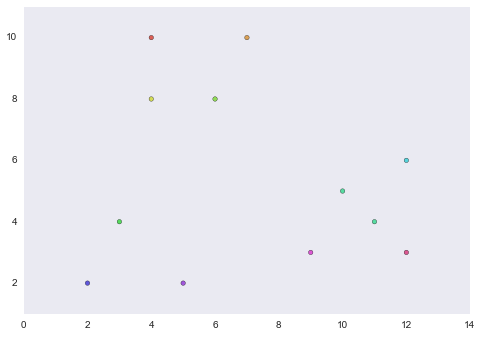

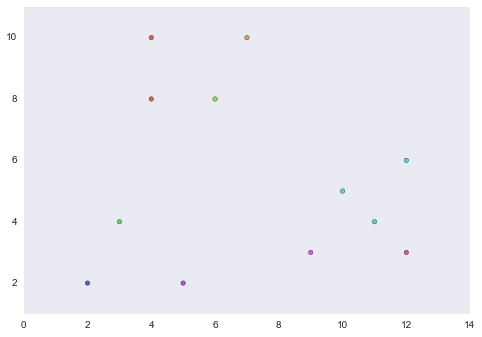

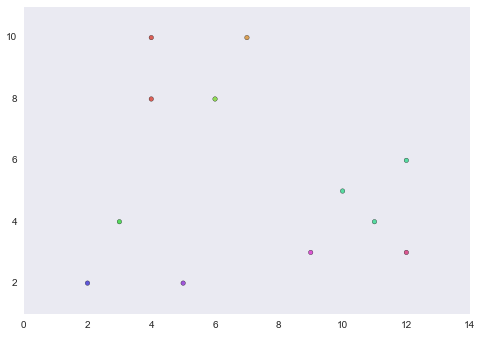

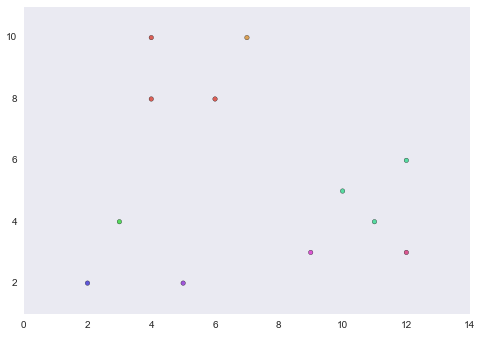

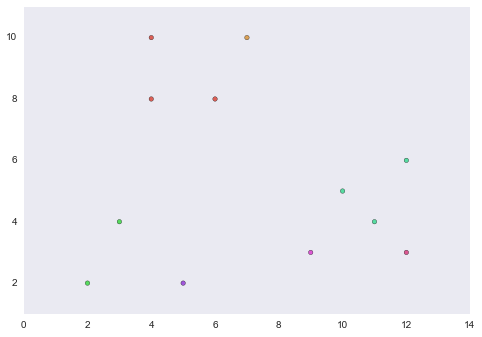

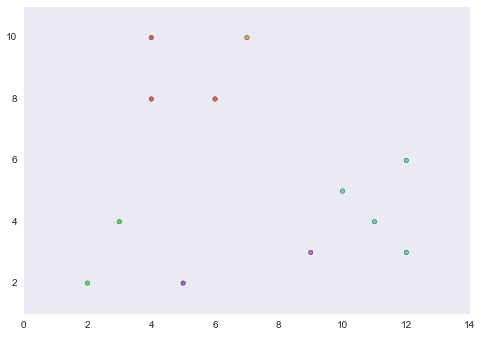

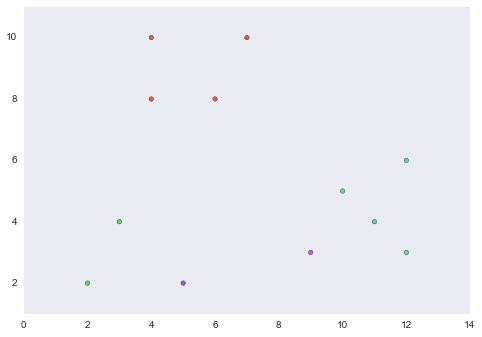

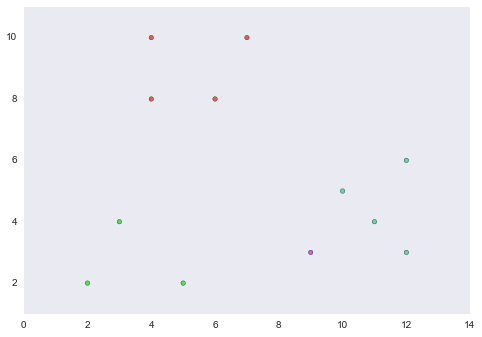

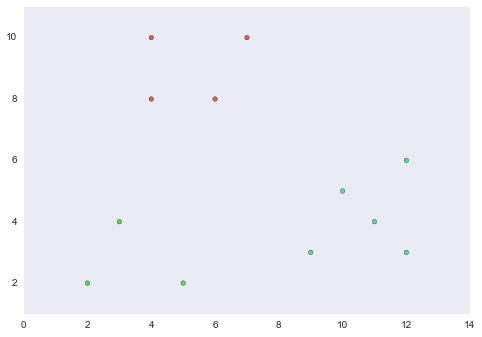

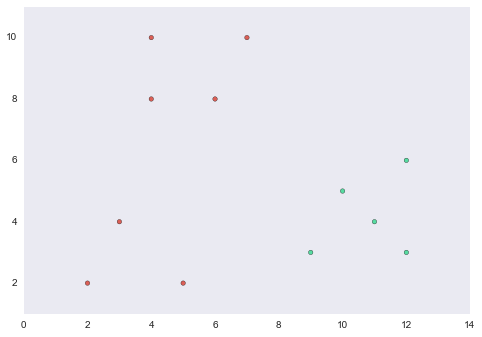

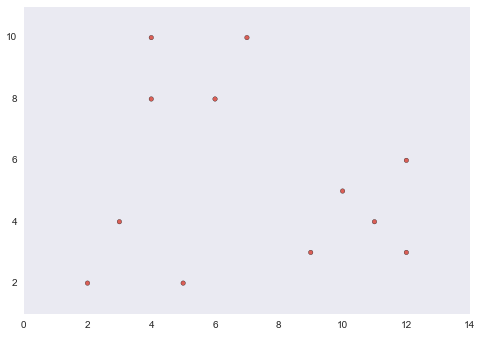

In [4]:
logger.setLevel('WARN')
df_p = df_points.copy()

test = Hierarchical_cluster()
test.cluster(df_p, 1, show=True)

In [5]:
import json
print json.dumps(df_p.merge_order[0], sort_keys=True, indent=4)

{
    "l": {
        "l": {
            "l": {
                "l": {
                    "l": [
                        0
                    ], 
                    "r": [
                        2
                    ]
                }, 
                "r": [
                    3
                ]
            }, 
            "r": [
                1
            ]
        }, 
        "r": {
            "l": {
                "l": [
                    4
                ], 
                "r": [
                    8
                ]
            }, 
            "r": [
                9
            ]
        }
    }, 
    "r": {
        "l": {
            "l": {
                "l": {
                    "l": [
                        5
                    ], 
                    "r": [
                        7
                    ]
                }, 
                "r": [
                    6
                ]
            }, 
            "r": [
                11
            

#### Efficiency
The algorithm is $O(n^3) = \sum_{i=n}^{2} C_n^2$, since it computes the distances between each pair of clusters in iteration.

Optimize:      
1. At first, computing the distance between all pairs. $O(n^2)$.

2. Save the distances information into a priority queue, in order to get the smallest distance in one step. $O(n^2)$.

3. When merging two clusters, we remove all entries involving them in the priority queue. $O(n \lg n) = 2n \times O(\lg n)$.

4. Compute all the distances between the new cluster and the remaining clusters.

### 7.3 K-means Algorithms
Assumptions: 1. Euclidean space; 2. $k$ is known in advance.

The heart of the algortim is the for-loop, in which we consider each point and assign it to the "closest" cluster.

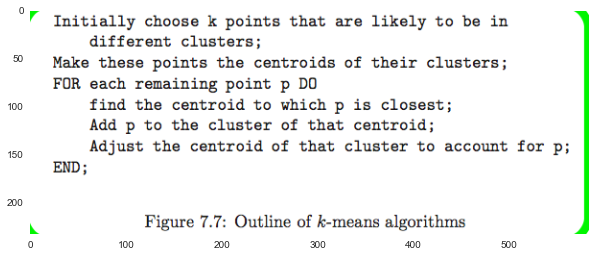

In [6]:
plt.figure(figsize=(10,16))
plt.imshow(plt.imread('./res/fig7_7.png'))

#### 7.3.2 Initializing Clusters for K-Means
We want to pick points that have a good chance of lying in different clusters.

two approaches:

1. Cluster a sample of the data, and pick a point from the $k$ clusters.

2. Pick points that are as far away from one another as possible.

```
Pick the first point at random;
WHILE there are fewer than k points DO
      ADD the point whose minimum disance from the selected points is as large as possible;
END;
```

#### 7.3.3 Picking the Right Value of k
If we take a measure of appropriateness for clusters, then we can use it to measure the quality of the clustering for various values of $k$ and so the right value of $k$ is guessed.

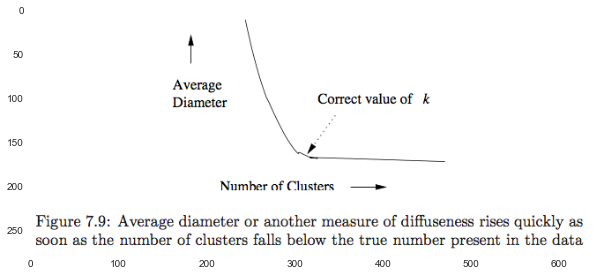

In [7]:
plt.figure(figsize=(10,16))
plt.imshow(plt.imread('./res/fig7_9.png'))

We can use a binary search to find the best values for $k$.

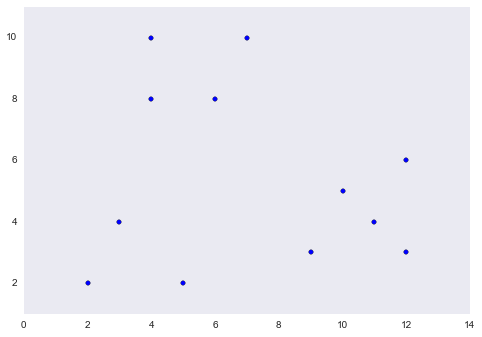

In [8]:
plt.scatter(df_points.x, df_points.y)

In [9]:
df_points['cluster'] = 0
df_points

,cluster,x,y
0,0,4,10
1,0,7,10
2,0,4,8
3,0,6,8
4,0,3,4
5,0,10,5
6,0,12,6
7,0,11,4
8,0,2,2
9,0,5,2


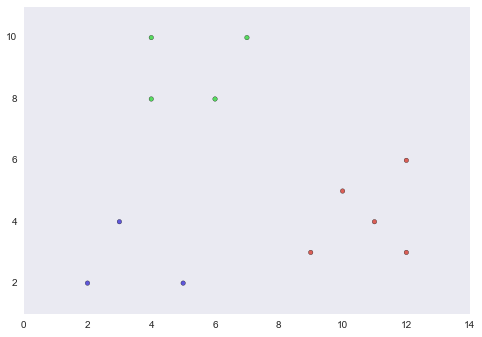

In [10]:
logger.setLevel('WARN')
class k_means_cluster():
    def __init__(self, max_itier=15):
        self.max_itier = max_itier
    
    def pick_init_points(self, df_points, k):
        df_clusters = df_points.sample(k, axis=0)
        df_clusters.reset_index(drop=True, inplace=True)
        df_clusters['cluster'] = df_clusters.index
        return df_clusters
    
    def assign_point_to_cluster(self, point, df_clusters):
        from scipy.spatial.distance import cdist
        logger.info('\n point:{}\n df_clusters:{}'.format(point, df_clusters))
        
        p = point[['x','y']].to_frame().T
        c = df_clusters.loc[:,['x','y']]
        logger.info('\n p:{}\n c:{}'.format(p, c))
        
        dist = cdist(p, c)
        logger.info('dist:{}'.format(dist))
        
        cluster = np.argmin(dist)
        logger.info('cluster:{}'.format(cluster))
        
        return pd.Series([cluster, point.x, point.y], index=['cluster', 'x', 'y'])
    
    def calc_centriod(self, df_points):
        centroid = df_points.groupby('cluster').mean()
        logger.info('\n centroid:\n{}'.format(centroid))
        return centroid
    
    def cluster(self, df_points, k):
        df_clusters = self.pick_init_points(df_points, k)
        
        for _ in xrange(self.max_itier): 
            df_points = df_points.apply(self.assign_point_to_cluster, args=(df_clusters,), axis=1)
            logger.info('iter: \n df_points:\n{}'.format(df_points))
            clusters = self.calc_centriod(df_points)
            
            #todo: stop condition
            
            df_clusters = clusters
            
        return df_points, df_clusters
        
        
    
test = k_means_cluster()
k = 3
cluster_colors = sns.color_palette("hls", k)
df_points_res, df_clusters_res = test.cluster(df_points, k)
plt.scatter(df_points_res.x, df_points_res.y, c=map(lambda x: cluster_colors[x], df_points_res.cluster.astype(np.int)))

#### 7.3.4 The Algorithm of Bradley, Fayyad, and Reina
designed to cluster data in a *high-dimensional* Euclidean space.

strong assumption about the shape of clusters:

1. normally distributed about a centriod.

2. the dimensions must be independent.

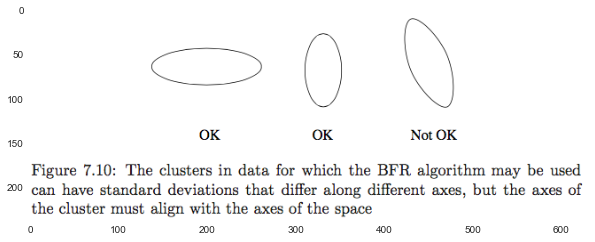

In [14]:
plt.imshow(plt.imread('./res/fig7_10.png'))

The points of the data file are read in chunks.

The main-memory data other than the chunk consists of three types of objects:

1. The Discard Set:     
   simple summaries of the clusters themselves.

2. The Compressed Set:      
   summaries of the points that have been found close to one another, but not close to any cluster. Each represented set of points is called a *minicluster*.

3. The Retained Set:     
   remaining points.

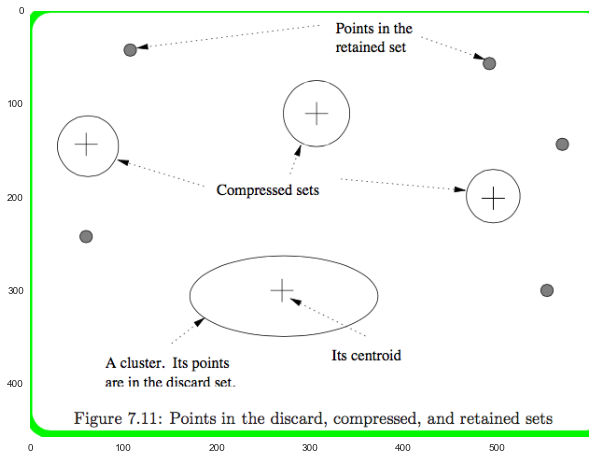

In [15]:
plt.imshow(plt.imread('./res/fig7_11.png'))

The discard and compressed sets are represented by $2d + 1$ values, if the data is $d$-dimensional.      
These numbers are:

+ The number of points represented, $N$.

+ The sum of the components of all the points in each dimension. a vector $SUM$ of length $d$.

+ The sum of the squares of the components of all the points in each dimension. a vector $SUMSQ$ of length $d$.

Our real goal is to represent a set of points by their count, their centroid and the standard deviation in each dimension.

+ count: $N$.

+ centriod: $SUM_i / N$.

+ standard deviation: $SUMSQ_i / N - (SUM_i / N)^2$

#### 7.3.5 Processing Data in the BFR algorithm
1. First, all points that are sufficiently close to the centriod of a cluster are added to that cluster, **Discard Set**.

2. For the points that are not sufficiently close to any centriod, we cluster them, along with the points in the retained set.       
   + Clusters of more than one point are summarized and added to the **Compressed Set**.    
   + Singleton clusters become the **Retained Set** of points.
   
3. Merge minicusters of compressed set if possible.

4. Points of discard and compressed set are written out to secondary memory.

5. Finally, if this is the last chunk of input data, we need do something with the compressed and retained set.      
   + Treat them as outliers.       
   + Assign them to the nearest cluster.     
   + Combine minclusters of compressed set.
   
##### How to decide whether a new point $p$ is close enough to a cluster?
1. Add $p$ to a cluster if it not only has the centriod closest to $p$, but it is very unlikely that, after all the points have been processed, some other cluster centriod will be found to be nearer to $p$.      
   complex statiscal calculation.      
   
2. We can measure the probability that, if $p$ belongs to a cluster, it would be found as far as it is from the centriod of that cluster.     
   normally distributed, independent $\to$ **Mahalanobis distance**:        
   Let $p = [p_1, p_2, \dotsc, p_d]$ be a point and $c = [c_1, c_2, \dotsc, c_d]$ be the centriod of a cluster.
   $$\sqrt{\sum_{i=1}^{d} ( \frac{p_i - c_i}{\sigma_i} )^2 }$$
   
   We choose that cluster whose centriod has the least Mahalanobis distance, and we add $p$ to that cluster provided the Mahalanobis distance is less than a threshold. 概率论上足够接近。

#### 7.3.6 Exercises for Section 7.3
`#todo`

### 7.4 The CURE Algorithm
CURE(Clustering Using REpresentatives)

1. assumes a Euclidean space

2. it does not assume anything about the shape of clusters.

Process:(key factor: fixed fraction for moving and how close is sufficient to merge).

1. Initialization      
   1. Sample, and then cluster.       
      Hierarchial clustering is advisable.     
      
   2. pick a subset as **representative points**(as far from one another as possible in the same cluster).
   
   3. Move each of the representative poins a **fixed fraction** of the distance between its location and the centriod of its cluster. (Euclidean space).
   
2. Merge: if two clusters have a pair of representative points that are **sufficiently close**.     
   Repeat until convergence.
   
3. Point assignment:      
   We assign $p$ to the cluster of the representative point that is closest to $p$.

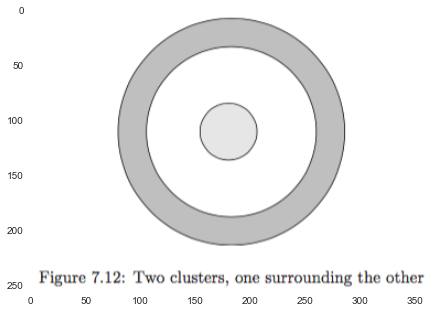

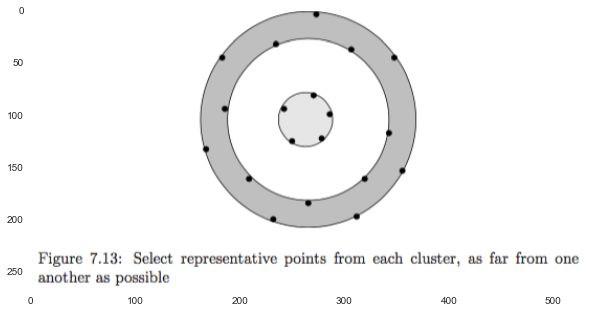

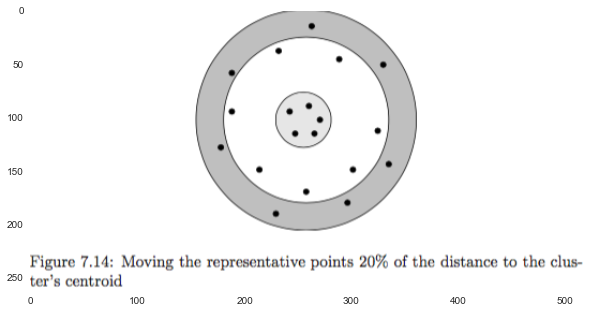

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(plt.imread('./res/fig7_12.png'))
plt.figure(figsize=(12,5))
plt.imshow(plt.imread('./res/fig7_13.png'))
plt.figure(figsize=(12,5))
plt.imshow(plt.imread('./res/fig7_14.png'))

#### 7.4.3 Exercises for Section 7.4
`#todo`

### 7.5 Clustering in Non-Euclidean Spaces
GRGPF algorithm:

1. sample $\to$ handles non-main-memory data.

2. hierarchical: B-tree      
   leaves: summaries of some clustes.     
   interior nodes: subsets of the information describing the clusters reachable through that node.

3. point-assignment.

#### 7.5.1 Representing Clusters
The following features form the representation of a cluster.

1. $N$, the number of points in the cluster.

2. The clustroid of the cluster and its ROWSUM: $\sum_{p_i \in C} \| p - p_i \|_2$

3. $k$ points that are closest to the clustroid, and their rowsums.      
   assumption: new clustriod would be one of them.

4. $k$ points that are furthest from the clustroid, and their rowsums.      
   assumption: if two clusters are close, then a pair of points distant from their respective clustriods would be close.

#### 7.5.2 Initializing the Cluster Tree
Each leaf of the tree holds as many cluster representations as can fit $\to$ B-tree or R-tree.

An interior node of the cluster tree holds a sample of the clustroids of its subtrees.

init:

1. taking a main-memory sample and clustering it hierarchically $\to$ a tree $T$.

2. selecting from $T$ certain of its points that represent clusters of approximately some disired size $n$ $\to$ the **leaf** of the cluster-representing tree.

3. grouping clusters with a commom ancestor in $T$ into **interior nodes**.      
   rebalancing, similar to the reorganization of a B-tree.

#### 7.5.3 Adding Points in the GRGPF Algorithm
From root to a leaf, we always choose the node closest to the new point $p$.

Finally,, we pick the cluster whose clustriod is closest to $p$. then:     

1. Add 1 to $N$.

2. Add $d(p,q)$ to sumrows of all $q$ that are in the cluster before.

3. estimate: $$ROWSUM(p) = ROWSUM(c) + N d^2(p,c)$$

4. if $p$ is one of the $k$ closest or furthest points from the clustroid, then replacing one.       
   if $p$ is closer to other points than the clustroid, then replacing it.
   
it is possible that the true clustroid will no longer be one of the original $k$ closest points $\to$ brought data on disk into main memory periodically for a recomputation of the cluster featrues.

#### 7.5.4 Splitting and Merging Clusters
##### split
The GRGPF Algorithm assumes that there is a limit on the radius ($\sqrt(ROWSUM(c)/N)$).      

If a cluster's radius grows too large $\to$ split it into two. As in a B-tree, this splitting can ripple all the way up to the root.

##### merge
If the tree is too large to fit in main memory, we raise the limit on the radius and consider merging pairs of clusters. and then:

+ recalculate all rowsums:      
  for $p \in c_1$, $c_1 \cap c_2 = C$:     
  $$ROWSUM_c(p) = ROWSUM_{c_1}(p) + N_{c_2} (d^2(p,c_1) + d^2(c_1,c_2)) + ROWSUM_{c_2}(c_2) $$

+ filter the new clustriod and $k$ closest points, $k$ furthest points from orginal $4k+1$ features of $c_1$ and $c_2$.

`#todo: exercise`

### 7.6 Clustering for Streams and Parallelism
#### 7.6.1 The Stream-Computin Model
N-points sliding window

we make no restriction regarding the space of point.

we assumes that the statistics of the stream elements varies with time, because sampling is good for constant statistics.

#### 7.6.2 A Streaming-Clustering Algorithm
Simplified BDMO Algorithm that builds on the methodology for counting ones in a steam in Sec. 4.6

Bucket:

1. its size is the number of points.

2. its size obey the restriction that there are one or two of each size, up to some limit. And the sequence of allowable bucket size does not need start with 1, but each size is twice the previous size.

3. all sizes: nondecreasing as we go back in time.

4. The contents:     

   + The size.
   
   + The timestamp.
   
   + A collection of records after clustering:
   
       - the number of points in the cluster.
       
       - the centriod.
       
       - Any other parameters necessary.

#### 7.6.3 Initializing Buckets
smallest bucket size $p$, a power of 2.

every $p$ stream elements arrived, we create a new bucket, and then cluster them.

#### 7.6.4 Mergin Buckets
1. drop the out-date buckets (go beyong $N$ points).

2. merge buckets if there are three identical size.

Three examples:

1. k-means approach in a Euclidean space.      
   assumption: the cluster are changing very slowly.
   
2. expect the cluster centriods to migrate sufficiently quickly.       
   create more than $k$ clusters in each bucket.
   
3. non-Euclidean space and no constrain on the number of clusters.      
   like GRGPF Algorithm.

#### 7.6.5 Ansering Queries
Question about the most recent $m$ points in the stream.

###### Answer
choose the smallest set of buckets that cover the last $m$ points. (Always less than $2m$).    

+ assume that the points between $2m$ and $m+1$ will not affect the result.

+ Or use a more complex bucketing shceme in Sec 4.6.6 to cover at most the last $m(1+\epsilon)$.

then pool all their clusters in the clusters and merge them.

#### 7.6.6 Clustering in a Parallel Environment
1. Create many Map tasks.     
   Each task is assigned a subset of the points, and cluster them.
   
2. only one Reduce task.      
   merge the clusters produced by Map tasks.

`#todo: exercise`